<a href="https://colab.research.google.com/github/cmgospod/DS-Unit-2-Regression-Classification/blob/master/module2/assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.
- [ ] Add your own stretch goal(s) !

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [0]:
location = df[['latitude', 'longitude', 'price']]
from sklearn.cluster import KMeans
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(location)
    sum_of_squared_distances.append(km.inertia_)
# Exploring clusters in physical location

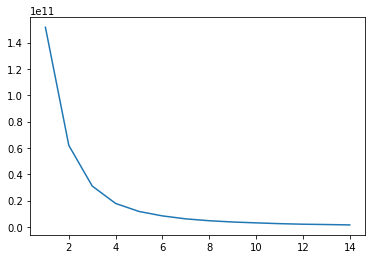

In [5]:
import matplotlib.pyplot as plt
plt.plot(K, sum_of_squared_distances)
# Elbow plot: three seems like a good number

In [6]:
n_clusters = 3
kmean = KMeans(n_clusters=n_clusters)
kmean.fit(location)
labels = kmean.labels_
label_series = pd.Series(labels)
location['clusters'] = label_series.values
location.clusters.value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    35129
1    12176
2     1512
Name: clusters, dtype: int64

In [0]:
mean_list = []
for cluster in range(0,n_clusters):
  clust = location[location['clusters'] == cluster]
  cluster_mean = np.mean(clust['price'])
  mean_list.append(cluster_mean)

In [8]:
for i in range(0,n_clusters):
  max_value = max(mean_list)
  series = location.loc[:,'clusters'].replace(to_replace={mean_list.index(max_value):n_clusters-i})
  mean_list[mean_list.index(max(mean_list))] = -1
location['clusters'].value_counts()
# Ordering the clusters by mean price, since this is a LINEAR regression

0    35129
1    12176
2     1512
Name: clusters, dtype: int64

In [0]:
df['neighborhood'] = location['clusters']
df.created = pd.to_datetime(df.created)
# Changing the date to a proper date format
df['pets_allowed'] = df['cats_allowed'] + df['dogs_allowed']
df.pets_allowed = np.sign(df.pets_allowed)
# pets_allowed measures whether either dogs or cats are allowed
df.interest_level = df.interest_level.replace(to_replace={'high':3,'medium':2,'low':1})
# Making interest_level numeric
def isreal(descrip):
  return len(str(descrip))
df['desc'] = df.description.map(isreal)
# Taking the length of the description

In [10]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,neighborhood,pets_allowed,desc
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,588
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,3,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,691
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,492
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,479


In [11]:
train = df[df['created'] < '2016-06-01']
test = df[df['created'] > '2016-06-01']
print(train.shape)
print(test.shape)
print(train.shape[0] + test.shape[0])
print(df.shape)

(31844, 37)
(16973, 37)
48817
(48817, 37)


In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = ['bedrooms', 'bathrooms', 'interest_level', 'pets_allowed', 'desc','neighborhood']
target = 'price'
X = train[features]
Y = train[target]
model.fit(X,Y)
y_pred = model.predict(X)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
testx = test[features]
testy = test[target]
y_test = model.predict(testx)
print(f'The intercept is {model.intercept_}, and the coefficients are {model.coef_}')
print('Mean squared error, mean absolute error, and r2 score')
print(f'Train: {mean_squared_error(Y, y_pred)}, {mean_absolute_error(Y, y_pred)}, {r2_score(Y, y_pred)}')
print(f'Test: {mean_squared_error(testy, y_test)}, {mean_absolute_error(testy, y_test)}, {r2_score(testy, y_test)}')

The intercept is 2015.5842340983024, and the coefficients are [ 1.42049000e+02  7.14958625e+02 -2.61475744e+02  4.38660474e+01
  2.00299707e-01  2.25575172e+03]
Mean squared error, mean absolute error, and r2 score
Train: 671612.4688040606, 587.3320449077362, 0.7837016536808862
Test: 651590.9327407688, 584.8354140053258, 0.7903518423504948


In [14]:

import plotly.express as px
px.scatter(df,x='longitude',y='latitude', color = 'neighborhood')